In [151]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import pywt
import scipy.stats

%matplotlib inline
plt.rcParams.update({'font.size': 12})

SaveFigs = False

In [108]:
def ridge_error(x,y, r=0):
    ''' ridge_error(x,y, lambda):
    predicts y [N by m] from x [N by p] by ridge regression. 
    
    Returns:
    * fit error as a frac of variance (scalar), 
    * weight [p by m], 
    * prediction [N by m].'''
    
    # append to bottom of matrices to make ridge regression
    n = 1
    p = x.shape[0]
    m = y.shape[0]
    x0 = np.block([[x, np.ones([n,1])]])
    x1 = np.block([[x, np.ones([n,1])], [r*np.eye(p), np.zeros([p,1])]])
    y1 = np.block([[y],[np.zeros((p,m))]])
    w,_,_,_ = np.linalg.lstsq(x1,y1, rcond=None)
    yhat = x0@w
    return np.mean((y-yhat)**2)/np.var(y), w, yhat

#ridge_error(np.array([[1],[0]]),np.array([[2],[1]]),1e10)

In [148]:
# parameters for noise process with block target
paramsB = Bunch(
    T = 200, # number of trials
    C = 10,# number of cells
    ex = 0, # sd of amplitude of exponential components in sources
    exp_tc = 15, # time constant of the exponentional components
    nx = 0.1, # amp of colored noise in sources
    tx = 0, #sd of amplitude of target in sources
    wx = 0, #sd of white noise in sources
    shift_rate = 2, # expected number of shifts during the recording, for each cell
    shift_width = 10, # width of shifts
    target_noise = False, # if true, target is pink noise series rather than blocks
    target_shift_amp = 1, # add a random shift component to target, with this amplitude (only if noise)
    signal_f_tc = False, # filter target with this timecourse before adding to x. False:don't
    bl = 50, # target block length, if target is blocks
    blrand = 20, # block length add random between 0 and this
    tau = 5000.0, # time constant of pink noise (trials)
    noise_nonlin = 1, # apply this power to the noise signal to make a nonlinear time series. 1 means linear
    blocks_stationary = False # shift blocks randomly to make them stationary?
)

#with noise target
paramsN = Bunch(paramsB)
paramsN.target_noise=True

#with actual predictability
paramsB1 = Bunch(paramsB)
paramsB1.tx = .1
paramsN1 = Bunch(paramsN)
paramsN1.tx = 1

paramList = (paramsB, paramsN, paramsB1, paramsN1)
nParams = len(paramList)

Seed = 5
R = 1 # number of repeats
N = 500 # number of resamples for p value

def make_shift_sequence(T,C,rate,width,pad=1):
    ''' make a timeseries of logistic shifts occuring at poisson times, of +-1 amplitude 
    (T,C): output size. rate: expected number of shifts per cell. width: logistic width
    pad(=1): what multiple of window to subset from (to make stationary)'''
    
    long_seq = np.zeros((pad*T,C))
    for c in range(C):
        shift_times = np.random.choice(pad*T,np.random.poisson(rate*pad))
        for t in shift_times:
            sign = np.sign(np.random.rand(1)-.5)
            long_seq[:,c] += 1/(1+np.exp(sign*(np.arange(pad*T)-t)/width))
    return long_seq[T*(pad-1)//2 : T*(pad+1)//2 ]

def make_data(params):
    ''' returns x, y
    x: T by C array of analog signals [pink noise + exponential drift + linear + target]
    y: target signal: binary block or another noise'''

    # weights for each cell
    expwt = params.ex * np.random.randn(params.C) 
    ywt = params.tx * np.random.randn(params.C)
    

    #parameters for filtered noise
    alpha = np.exp(-2.0/params.tau)
    b = np.array([np.sqrt(1-alpha)])
    a = np.array([1, -np.sqrt(alpha)])
    
    # make filtered noise
    x0,_ =  signal.lfilter(b,a, np.random.randn(params.T,params.C), axis=0, zi=np.random.randn(1,params.C)) 
    
     
    x = params.nx*(x0**params.noise_nonlin) \
        + expwt[None,:] * np.exp(-np.arange(params.T)[:,None]/params.exp_tc) \
        + params.wx * np.random.randn(params.T, params.C) \
        + make_shift_sequence(params.T, params.C, params.shift_rate, params.shift_width)
        
    if params.target_noise:
        y0,_ =  signal.lfilter(b,a, np.random.randn(params.T,1), axis=0, zi=np.random.randn(1,1)) 
        y = params.nx*(y0**params.noise_nonlin) \
            +make_shift_sequence(params.T, 1, params.shift_rate, params.shift_width)
    else: 
        #make blocks
        nBlx = 1000 # way too many blocks, because we might randomize from it
        blockLen = np.random.randint(params.bl, params.bl+params.blrand, nBlx)
        flipTimes = np.cumsum(blockLen)
        y0 = np.cumsum(np.bincount(flipTimes, (-1)**np.arange(nBlx)))


        if params.blocks_stationary:
            startPoint = np.random.randint(len(y0)//2)
            y = y0[startPoint:startPoint+params.T,None]
        else:
            y = y0[:params.T,None]
    
    
    # now add part of target if needed
    if params.signal_f_tc:
        alpha2 = -np.exp(1.0/params.signal_f_tc)
        a2 = np.array([alpha2/(1+alpha2), 1/(1+alpha2)])  
        yf,_ = signal.lfilter([1],a2,y, axis=0, zi=-y[0,None]/alpha2)
        x += ywt[None,:] * yf
    else:
        x += ywt[None,:] * y
    
    # scale 0 to 1
    y = (y-y.min(0))/(y.max(0)-y.min(0))
    x = (x-x.min(0))/(x.max(0)-x.min(0))
    
    
    return x,y


data set 0
data set 1
data set 2
data set 3


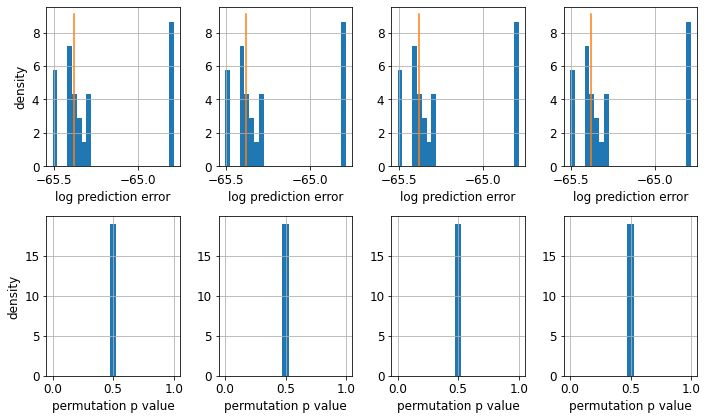

In [149]:
## Session permutation
S = 4 #number of sessions


if 1: # make 0 to skip calculations
    np.random.seed(Seed)
        
    p_perm = np.zeros((nParams,R))
    uScore_perm = np.zeros(nParams)
    pScore_perm = np.zeros((nParams,np.math.factorial(S)))

    for i, params in enumerate(paramList):
        print('data set %d'%i)
        for r in range(R):

            uScore_perm[i]=0
            for s in range(S):
                #x[s],y[s] = make_data(params)
                x[s] = JC047_pupil[s]
                y[s] = JC047_performance[s]
                
                #sc,_,_ = ridge_error(x[s],y[s],0)
                uScore_perm[i] += sc

            pScore_perm[i]=0
            for j,p in enumerate(itertools.permutations(range(S))):
                for s in range(S):
                    sc,_,_ = ridge_error(x[s],y[p[s]],0)
                    pScore_perm[i,j] += sc

            p_perm[i,r]=stats.percentileofscore(pScore_perm[i], uScore_perm[i])/100
        
fig, ax = plt.subplots(2,len(paramList), figsize=(10,6))
for i in range(nParams):
    ax[0,i].hist(np.log(pScore_perm[i]),25, density=True)
    ax[0,i].plot(np.full(2,np.log(uScore_perm[i])), ax[0,i].get_ylim())
    ax[0,i].grid()
    ax[1,i].hist(p_perm[i],np.linspace(0,1,20), density=True)
    ax[1,i].grid()
    ax[0,i].set_xlabel('log prediction error')
    ax[1,i].set_xlabel('permutation p value')


ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')

plt.tight_layout()
if SaveFigs: plt.savefig('SessionPerm.png',dpi=300)